
American Community Survey (ACS) – Vision and Eye Health Surveillance
https://chronicdata.cdc.gov/Vision-Eye-Health/American-Community-Survey-ACS-Vision-and-Eye-Healt/thir-stei

In [2]:
from datetime import datetime, timedelta
import geopandas as gpd
import io
import json
import pandas as pd
import mapclassify as mc
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import seaborn as sns
from io import StringIO
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=np.inf)

In [3]:
# American Community Survey (ACS) – Vision and Eye Health Surveillance 
params_acs = {
    #'$where': "created_date between '2018-01-01T00:00:00' and '2023-12-31T23:59:59'",
    '$limit': 600000  # Limit the number of records, adjust as needed
}
acs_url = 'https://chronicdata.cdc.gov/resource/thir-stei.geojson'

In [4]:
acs_response = requests.get(acs_url, params=params_acs)
acs_json = acs_response.json()
acs_gdf = gpd.GeoDataFrame.from_features(acs_json['features'])
print(len(acs_gdf))
acs_gdf.head()

510578


,geometry,responseid,question,low_confidence_limit,data_value_unit,data_value,raceethnicity,riskfactorresponse,locationid,raceethnicityid,sample_size,age,numerator,high_confidence_limit,categoryid,response,riskfactorresponseid,questionid,locationdesc,data_value_footnote,riskfactor,data_value_type,data_value_footnote_symbol,geographiclevel,category,datavaluetypeid,topic,yearend,riskfactorid,topicid,genderid,datasource,yearstart,locationabbr,ageid,gender
0,None,RYES,Percentage of people who are blind or have serious difficulty seeing even when wearing glasses,None,%,None,All races,Advanced degree,59,ALLRACE,None,0-17 years,None,None,CBLIND,Yes,EDADV,ACSBL,National,Value suppressed,Education,Crude Prevalence,#,National,Blind or Difficulty Seeing,CRDPREV,Visual Function,2019,RFEDUC,TVFUNC,GF,ACS,2019,US,AGE017,Female
1,None,RYES,Percentage of people who are blind or have serious difficulty seeing even when wearing glasses,None,%,None,All races,Advanced degree,59,ALLRACE,None,0-17 years,None,None,CBLIND,Yes,EDADV,ACSBL,National,Value suppressed,Education,Crude Prevalence,#,National,Blind or Difficulty Seeing,CRDPREV,Visual Function,2019,RFEDUC,TVFUNC,GM,ACS,2019,US,AGE017,Male
2,None,RYES,Percentage of people who are blind or have serious difficulty seeing even when wearing glasses,0.52,%,0.58,All races,Advanced degree,59,ALLRACE,83921,18-39 years,50596,0.66,CBLIND,Yes,EDADV,ACSBL,National,None,Education,Crude Prevalence,None,National,Blind or Difficulty Seeing,CRDPREV,Visual Function,2019,RFEDUC,TVFUNC,GALL,ACS,2019,US,AGE1839,All genders
3,None,RYES,Percentage of people who are blind or have serious difficulty seeing even when wearing glasses,1.48,%,1.65,"Black, non-Hispanic",Total,59,BLK,43058,18-39 years,108174,1.84,CBLIND,Yes,RFTOT,ACSBL,National,None,All participants,Crude Prevalence,None,National,Blind or Difficulty Seeing,CRDPREV,Visual Function,2019,RFAPAR,TVFUNC,GM,ACS,2019,US,AGE1839,Male
4,None,RYES,Percentage of people who are blind or have serious difficulty seeing even when wearing glasses,2.52,%,2.57,All races,Total,59,ALLRACE,548191,40-64 years,1361193,2.63,CBLIND,Yes,RFTOT,ACSBL,National,None,All participants,Crude Prevalence,None,National,Blind or Difficulty Seeing,CRDPREV,Visual Function,2019,RFAPAR,TVFUNC,GF,ACS,2019,US,AGE4064,Female


<AxesSubplot:>

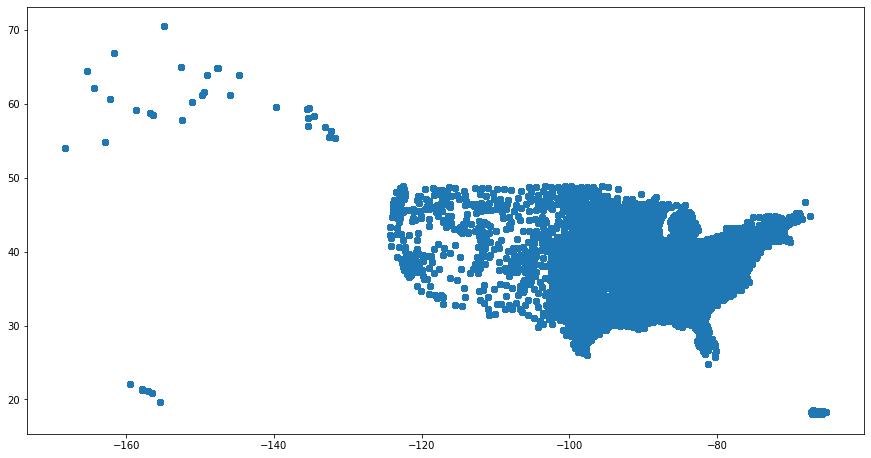

In [5]:
acs_gdf.plot(figsize=(15,15))

## EDA Columns 

In [6]:
acs_gdf.dtypes

geometry                      geometry
responseid                      object
question                        object
low_confidence_limit            object
data_value_unit                 object
data_value                      object
raceethnicity                   object
riskfactorresponse              object
locationid                      object
raceethnicityid                 object
sample_size                     object
age                             object
numerator                       object
high_confidence_limit           object
categoryid                      object
response                        object
riskfactorresponseid            object
questionid                      object
locationdesc                    object
data_value_footnote             object
riskfactor                      object
data_value_type                 object
data_value_footnote_symbol      object
geographiclevel                 object
category                        object
datavaluetypeid          

# Filter ACS

In [7]:
print(len(acs_gdf))

# County only include all ages 

acs_gdf['geo_age'] = acs_gdf['geographiclevel'] + ':' + acs_gdf['age']

acs_blv_gdf = acs_gdf[  (acs_gdf['riskfactorresponse'] == 'Total')
                      & (acs_gdf['raceethnicity'] == 'All races')
                      & (acs_gdf['gender'] == 'All genders')
                      & (acs_gdf['yearstart'] == '2019')
                      & (acs_gdf['riskfactor'] == 'All participants')
                      & ~(acs_gdf['geo_age'].isin(['County:18-34 years',
                                                  'County:75 years and older',
                                                  'County:65-74 years',
                                                  'County:0-4 years',
                                                  'County:5-17 years',
                                                  'County:35-64 years']))
                     ]

acs_blv_gdf['blv_rate'] = acs_blv_gdf['data_value'].astype(float)
print(len(acs_blv_gdf))

510578
3531


In [8]:
acs_col_list = list(acs_blv_gdf.columns[1:])
acs_col_list.remove('low_confidence_limit')
acs_col_list.remove('high_confidence_limit')
acs_col_list.remove('data_value')
acs_col_list.remove('locationid')
acs_col_list.remove('sample_size')
acs_col_list.remove('numerator')
acs_col_list.remove('locationdesc') # National, states and counties - LABELING 
acs_col_list.remove('responseid') # Single value = RYES
acs_col_list.remove('question') # Single value = Percentage of people who are blind or have serious difficulty seeing even when wearing glasses
acs_col_list.remove('data_value_unit') # Single value = %
acs_col_list.remove('categoryid') # Single value = CBLIND
acs_col_list.remove('response') # Single value = Yes
acs_col_list.remove('data_value_type') # Single value = Value suppressed
acs_col_list.remove('questionid') # Single value = ACSBL
acs_col_list.remove('data_value_footnote') # Single value = Value suppressed **** This might be relevant 
acs_col_list.remove('data_value_footnote_symbol') # Single value = #
acs_col_list.remove('category') # Single value = Blind or Difficulty Seeing
acs_col_list.remove('topicid') # Single value = Visual Function
acs_col_list.remove('topic') # Single value =  Visual Function
acs_col_list.remove('datavaluetypeid') # Single value =  CRDPREV
acs_col_list.remove('datasource') # Single value =  ACS
acs_col_list.remove('locationabbr') # Abbreviated National, states and counties - LABELING 
acs_col_list.remove('riskfactorid') # Duplicate info of another field 
acs_col_list.remove('riskfactorresponseid') # Duplicate info of another field 
acs_col_list.remove('raceethnicityid') # Duplicate info of another field 
acs_col_list.remove('ageid') # Duplicate info of another field 
acs_col_list.remove('genderid') # Duplicate info of another field 
acs_col_list.remove('raceethnicity') # Duplicate info of another field 
acs_col_list.remove('riskfactorresponse') # Duplicate info of another field 
acs_col_list.remove('riskfactor')
acs_col_list.remove('yearstart') 
acs_col_list.remove('yearend')
acs_col_list.remove('gender')
acs_col_list.remove('geo_age')
acs_col_list.remove('blv_rate')



acs_data_fields = ['locationdesc','blv_rate']

for col in acs_col_list:
    print('\n' + col +':')
    print(acs_blv_gdf[col].value_counts())
    


age:
All ages              3271
65-84 years             52
0-17 years              52
18-39 years             52
40-64 years             52
85 years and older      52
Name: age, dtype: int64

geographiclevel:
County      3219
State        306
National       6
Name: geographiclevel, dtype: int64


In [9]:
# Run value counts for the national level 
acs_national_gdf = acs_blv_gdf[acs_blv_gdf['locationdesc']=='National']

for col in acs_col_list:
    print('\n' + col +':')
    print(acs_national_gdf[col].value_counts())


age:
65-84 years           1
0-17 years            1
18-39 years           1
40-64 years           1
85 years and older    1
All ages              1
Name: age, dtype: int64

geographiclevel:
National    6
Name: geographiclevel, dtype: int64


In [10]:
print(len(acs_national_gdf))
acs_national_gdf[acs_col_list+acs_data_fields].head(50)

6


,age,geographiclevel,locationdesc,blv_rate
7,65-84 years,National,National,5.08
1937,0-17 years,National,National,0.75
25874,18-39 years,National,National,1.28
53340,40-64 years,National,National,2.61
99580,85 years and older,National,National,15.47
123156,All ages,National,National,2.41


In [11]:
# df=acs_national_singleval_gdf

# # Sort the DataFrame by yearend
# df = df.sort_values(by='yearend')

# # Create a figure and axis object
# fig, ax = plt.subplots()

# # Plot the data value as dots and the confidence intervals as error bars
# ax.plot(df['yearend'], df['data_value'], 'o', label='Data Value')
# ax.errorbar(df['yearend'], df['data_value'], yerr=(df['data_value']-df['low_confidence_limit'], df['high_confidence_limit']-df['data_value']), fmt='none', capsize=3, label='Confidence Interval')

# # Set axis labels and title
# ax.set_xlabel('Year')
# ax.set_ylabel('Data Value')
# ax.set_title('Data Value with Confidence Intervals over Time')

# # Show the legend
# ax.legend()

# # Show the plot
# plt.show()



In [12]:
# View rows
acs_final_fields = ['locationdesc'] + acs_col_list + acs_data_fields
acs_blv_gdf[acs_final_fields].head(5)


,locationdesc,age,geographiclevel,locationdesc,blv_rate
7,National,65-84 years,National,National,5.08
323,Texas,0-17 years,State,Texas,0.89
461,Hawaii,0-17 years,State,Hawaii,0.32
606,Montana,0-17 years,State,Montana,1.10
1235,Washington,0-17 years,State,Washington,0.83


In [13]:
# Find National Average 
national_average = acs_blv_gdf[(acs_blv_gdf['geographiclevel'] == 'National') & 
                               (acs_blv_gdf['yearend'] == '2019') & 
                               (acs_blv_gdf['age'] == 'All ages')]['data_value'].astype(float).values[0]

# Normalize by the national average
#acs_blv_gdf['blv_standardized'] = acs_blv_gdf['blv_rate'] / national_average

# Percent differnt 
acs_blv_gdf['blv_standardized'] = (acs_blv_gdf['blv_rate'] - national_average) / national_average



In [14]:
# Find National Average for All Ages
national_average_all_ages = acs_blv_gdf[(acs_blv_gdf['geographiclevel'] == 'National') & 
                               (acs_blv_gdf['yearend'] == '2019') & 
                               (acs_blv_gdf['age'] == 'All ages')]['blv_rate'].astype(float).values[0]

# Find National Average for each age group
national_averages_by_age = acs_blv_gdf[(acs_blv_gdf['geographiclevel'] == 'National') & 
                                       (acs_blv_gdf['yearend'] == '2019') & 
                                       (acs_blv_gdf['age'] != 'All ages')].groupby('age')['blv_rate'].mean().to_dict()

# Normalize by the national average for each age group
acs_blv_gdf['blv_standardized'] = acs_blv_gdf.apply(lambda row: 
                                                    row['blv_rate'] / national_averages_by_age[row['age']] 
                                                    if row['age'] != 'All ages' 
                                                    else (row['blv_rate'] - national_average_all_ages) / national_average_all_ages, 
                                                    axis=1)


In [15]:
acs_blv_gdf[acs_final_fields+['blv_standardized']].sort_values(by='blv_standardized', ascending=True).head(20)

,locationdesc,age,geographiclevel,locationdesc,blv_rate,blv_standardized
129683,Loving County,All ages,County,Loving County,0.00,-1.000000
124654,Grand County,All ages,County,Grand County,0.21,-0.912863
127827,Vieques Municipality,All ages,County,Vieques Municipality,0.50,-0.792531
121513,Mellette County,All ages,County,Mellette County,0.50,-0.792531
126520,Sully County,All ages,County,Sully County,0.54,-0.775934
119495,Daggett County,All ages,County,Daggett County,0.58,-0.759336
125678,Gilpin County,All ages,County,Gilpin County,0.60,-0.751037
119964,De Baca County,All ages,County,De Baca County,0.60,-0.751037
131169,Sierra County,All ages,County,Sierra County,0.60,-0.751037
120447,Castro County,All ages,County,Castro County,0.63,-0.738589


In [16]:
acs_blv_gdf[acs_final_fields+['blv_standardized']].sort_values(by='blv_standardized', ascending=False).head(20)

,locationdesc,age,geographiclevel,locationdesc,blv_rate,blv_standardized
124915,Guanica Municipality,All ages,County,Guanica Municipality,24.53,9.178423
122678,Sabana Grande Municipality,All ages,County,Sabana Grande Municipality,18.93,6.854772
122108,Coamo Municipality,All ages,County,Coamo Municipality,16.72,5.937759
121313,Kalawao County,All ages,County,Kalawao County,16.39,5.800830
121337,Yauco Municipality,All ages,County,Yauco Municipality,15.95,5.618257
124279,Aguada Municipality,All ages,County,Aguada Municipality,15.16,5.290456
128564,Cayey Municipality,All ages,County,Cayey Municipality,15.16,5.290456
122973,Santa Isabel Municipality,All ages,County,Santa Isabel Municipality,14.93,5.195021
119696,Ciales Municipality,All ages,County,Ciales Municipality,14.43,4.987552
126268,Anasco Municipality,All ages,County,Anasco Municipality,14.27,4.921162


In [17]:
export_fields = ['geometry']+acs_final_fields+['blv_standardized']
final_acs_blv_gdf = acs_blv_gdf[export_fields].sort_values(by='blv_standardized', ascending=False)
final_acs_blv_gdf.to_csv

parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'blind_low_vision_rates.csv')  # construct the file path
final_acs_blv_gdf[export_fields].to_csv(file_path, index=False)


In [18]:
final_acs_blv_gdf.geographiclevel.value_counts()

County      3219
State        306
National       6
Name: geographiclevel, dtype: int64

# Load the Obesity Data

# Not going to use this dataset. - too few years and data is duplicative with the next dataset.

### 2015

Obesity Data 

https://catalog.data.gov/dataset/national-obesity-by-state-d765a

https://data-lakecountyil.opendata.arcgis.com/datasets/lakecountyil::national-obesity-by-state.geojson?outSR=%7B%22latestWkid%22%3A3435%2C%22wkid%22%3A102671%7D

In [19]:
obesity_url = 'https://data-lakecountyil.opendata.arcgis.com/datasets/lakecountyil::national-obesity-by-state.geojson'
            
obesity_response = requests.get(obesity_url) #, params=params_obesity)
obesity_json = obesity_response.json()
obesity_gdf = gpd.GeoDataFrame.from_features(obesity_json['features'])
print(len(obesity_gdf))
obesity_gdf.head()

52


geometry  \
0  MULTIPOLYGON (((-106.62345 31.91404, -106.63012 31.97126, -106.61850 32.00050, -106.37718 32.00125, -106.20071 32.00179, -105.99798 32.00198, -105.75054 32.00221, -105.15400 32.00050, -104.91831 32.00048, -104.84777 32.00047, -104.64354 32.00045, -104.02453 32.00002, -103.98022 32.00004, -103.72286 32.00017, -103.32651 32.00038, -103.06443 32.00052, -103.06443 32.08706, -103.06443 32.14501, -103.06471 32.52220, -103.06477 32.58799, -103.06490 32.84936, -103.06348 32.95911, -103.06011 33.21923, -103.05650 33.38842, -103.05262 33.57060, -103.04736 33.82468, -103.04353 34.07939, -103.04357 34.11284, -103.04384 34.30262, -103.04386 34.31276, -103.04396 34.37956, -103.04308 34.61979, -103.04278 34.74737, -103.04275 34.95411, -103.04272 35.14474, -103.04263 35.18316, -103.04156 35.62249, -103.04137 35.73928, -103.04083 36.05524, -103.04193 36.50045, -103.00244 36.50040, -102.16247 36.50033, -102.03235 36.50007, -101.82657 36.49966, -101.62392 36.49953, -101.08516 36.49925, -100.95416 36.49954, -100.88418 36.49969, -100.59262 36.49948, -100.54615 36.49951, -100.31103 36.49969, -100.00377 36.49971, -100.00041 36.49971, -100.00041 36.05568, -100.00040 35.88095, -100.00040 35.61912, -100.00040 35.42237, -100.00039 35.18271, -100.00039 35.03039, -100.00039 34.74637, -100.00039 34.56051, -99.99764 34.56114, -99.92934 34.57672, -99.84207 34.50694, -99.81819 34.48785, -99.76489 34.43527, -99.69647 34.38104, -99.60003 34.37469, -99.58449 34.40768, -99.47503 34.39688, -99.47098 34.39648, -99.42044 34.38047, -99.39496 34.44210, -99.35042 34.43709, -99.27535 34.38660, -99.22162 34.32538, -99.21161 34.31398, -99.18952 34.21432, -99.13156 34.20936, -99.05881 34.20126, -99.00292 34.20879, -98.95233 34.20468, -98.94023 34.20369, -98.87224 34.16045, -98.80682 34.15591, -98.73724 34.13100, -98.69008 34.13316, -98.64808 34.16445, -98.61036 34.15622, -98.57714 34.14897, -98.52821 34.09497, -98.47507 34.06427, -98.42354 34.08196, -98.41443 34.08508, -98.39845 34.12846, -98.36403 34.15711, -98.31876 34.14643, -98.22529 34.12725, -98.16913 34.11418, -98.13849 34.14121, -98.12338 34.15455, -98.09934 34.10430, -98.09910 34.04864, -98.08285 34.00242, -98.00567 33.99597, -97.94758 33.99106, -97.95370 33.92438, -97.95191 33.89123, -97.95122 33.87843, -97.86577 33.84940, -97.80348 33.88020, -97.75984 33.92522, -97.67178 33.99138, -97.60910 33.96810, -97.59616 33.92211, -97.56125 33.89907, -97.55828 33.89710, -97.48651 33.91700, -97.48415 33.91390, -97.45148 33.87094, -97.44420 33.82378, -97.37295 33.81946, -97.31825 33.86513, -97.24619 33.90035, -97.20615 33.91429, -97.16664 33.84732, -97.20566 33.80983, -97.14940 33.72197, -97.09108 33.73512, -97.08786 33.77410, -97.07860 33.81276, -97.05585 33.85575, -96.98557 33.88653, -96.98875 33.91847, -96.95232 33.94459, -96.94462 33.94502, -96.93435 33.94559, -96.90526 33.94722, -96.89720 33.90296, -96.85060 33.84722, -96.79428 33.86889, -96.77677 33.84198, -96.71243 33.83164, -96.68211 33.87665, -96.65990 33.91667, -96.59468 33.88302, -96.59012 33.88067, -96.59293 33.83092, -96.57294 33.81910, -96.52387 33.81812, -96.50229 33.77347, -96.43646 33.78006, -96.40351 33.74629, -96.37967 33.71554, -96.36314 33.69422, -96.30740 33.73501, -96.27728 33.76974, -96.22903 33.74803, -96.17303 33.80057, -96.15164 33.83195, -96.06393 33.84153, -95.93533 33.87510, -95.88750 33.86386, -95.84489 33.86043, -95.82060 33.85847, -95.78965 33.87244, -95.73752 33.89597, -95.66999 33.90585, -95.60366 33.92720, -95.55692 33.92703, -95.52533 33.88549, -95.44738 33.86886, -95.35235 33.86780, -95.31046 33.87385, -95.28345 33.87775, -95.25363 33.92972, -95.22640 33.96196, -95.15591 33.93849, -95.14947 33.93634, -95.09501 33.90482, -95.04658 33.86257, -94.98166 33.85229, -94.93957 33.81051, -94.90228 33.77630, -94.84164 33.73944, -94.76615 33.74804, -94.73194 33.72084, -94.71487 33.70727, -94.63059 33.67341, -94.57288 33.66989, -94.52893 33.62185, -94.48588 33.63787, -94.41906 33.57722, -94.38806 33.56552, -94.35417 33.55646, -94.3384

<AxesSubplot:>

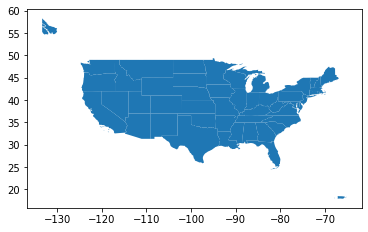

In [20]:
obesity_gdf.plot()
# Missing Hawaii geometry and Alaska is chopped

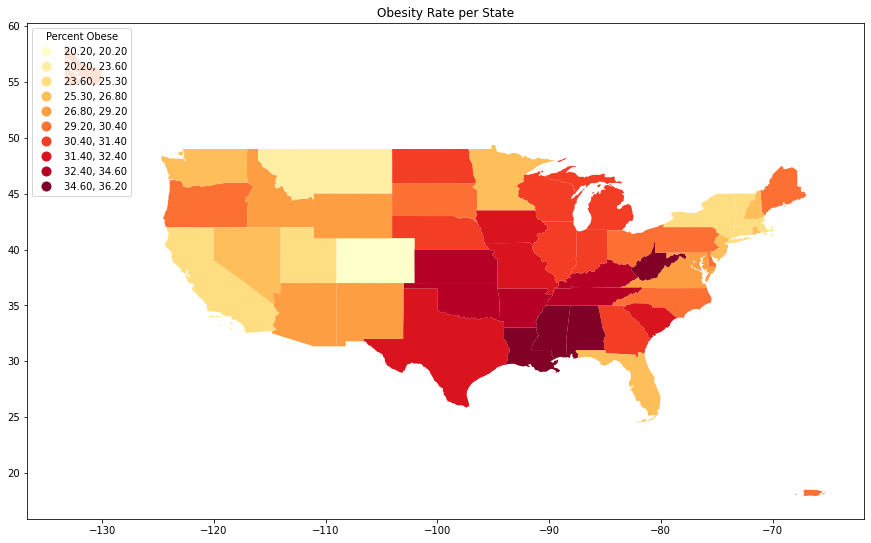

In [21]:
# Natural Breaks (Jenks)
fig, ax = plt.subplots(1, 1, figsize=(15, 14))
obesity_gdf.plot(column='Obesity',
                    ax=ax,
                    cmap='YlOrRd',
                    scheme='natural_breaks',
                    k=10,
                    legend=True,
                    missing_kwds={'color': 'lightgray'},
                    legend_kwds={'loc': 'upper left', 'title': 'Percent Obese'})
plt.title('Obesity Rate per State')
plt.show()


# Load the Chronic Illness Data 

CDC's Division of Population Health provides cross-cutting set of 124 indicators that were developed by consensus and that allows states and territories and large metropolitan areas to uniformly define, collect, and report chronic disease data that are important to public health practice and available for states, territories and large metropolitan areas. In addition to providing access to state-specific indicator data, the CDI web site serves as a gateway to additional information and data resources.


https://catalog.data.gov/dataset/u-s-chronic-disease-indicators-cdi/resource/d831fdf6-8362-4795-8a75-6e105325bc94

In [22]:
cdc_url = 'https://data.cdc.gov/api/views/g4ie-h725/rows.csv'
cdc_response = requests.get(cdc_url)
cdc_csv = io.BytesIO(cdc_response.content)
cdc_original_df = pd.read_csv(cdc_csv)
print(len(cdc_original_df))
cdc_original_df.head()

1185676


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,GeoLocation,ResponseID,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,916,916.0,NaN,NaN,NaN,NaN,Gender,Male,NaN,NaN,NaN,NaN,POINT (-92.27449074299966 34.74865012400045),NaN,5,AST,AST3_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,2227,2227.0,NaN,NaN,NaN,NaN,Overall,Overall,NaN,NaN,NaN,NaN,POINT (-106.13361092099967 38.843840757000464),NaN,8,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,708,708.0,NaN,NaN,NaN,NaN,Overall,Overall,NaN,NaN,NaN,NaN,POINT (-77.036871 38.907192),NaN,11,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,3520,3520.0,NaN,NaN,NaN,NaN,Gender,Female,NaN,NaN,NaN,NaN,POINT (-83.62758034599966 32.83968109300048),NaN,13,AST,AST3_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,123,123.0,NaN,NaN,NaN,NaN,Race/Ethnicity,Hispanic,NaN,NaN,NaN,NaN,POINT (-84.71439026999968 44.6613195430005),NaN,26,AST,AST3_1,NMBR,RACE,HIS,NaN,NaN,NaN,NaN


In [42]:
cdc_original_df.StratificationCategory3.value_counts()

Series([], Name: StratificationCategory3, dtype: int64)

In [24]:
cdc_original_df.dtypes

YearStart                      int64
YearEnd                        int64
LocationAbbr                  object
LocationDesc                  object
DataSource                    object
Topic                         object
Question                      object
Response                     float64
DataValueUnit                 object
DataValueType                 object
DataValue                     object
DataValueAlt                 float64
DataValueFootnoteSymbol       object
DatavalueFootnote             object
LowConfidenceLimit           float64
HighConfidenceLimit          float64
StratificationCategory1       object
Stratification1               object
StratificationCategory2      float64
Stratification2              float64
StratificationCategory3      float64
Stratification3              float64
GeoLocation                   object
ResponseID                   float64
LocationID                     int64
TopicID                       object
QuestionID                    object
D

## Filters

In [25]:
# Filter the data to only 2019 ( most recent year)
print(len(cdc_original_df))
cdc_df = cdc_original_df[(cdc_original_df['YearStart']==2019) \
                & (cdc_original_df['StratificationCategory1']=='Overall') \
                & (cdc_original_df['Stratification1']=='Overall') \
                & ( ( (cdc_original_df['DataValueType'] == 'Age-adjusted Rate') \
                    | (cdc_original_df['DataValueType'] == 'Age-adjusted Prevalence') ) \
                | ( cdc_original_df['Question'].isin(['Life expectancy at birth','Poverty'])) ) \
               ]
print(len(cdc_df))

1185676
4232


In [26]:
cdc_col_list = list(cdc_df.columns)
cdc_col_list.remove('YearStart')
cdc_col_list.remove('YearEnd')
cdc_col_list.remove('LowConfidenceLimit')
cdc_col_list.remove('HighConfidenceLimit')
cdc_col_list.remove('DataValue')
cdc_col_list.remove('DataValueAlt')
cdc_col_list.remove('Response') # Empty
cdc_col_list.remove('DataValueFootnoteSymbol') # Single value = #
cdc_col_list.remove('TopicID') # Duplicate info of another field  
cdc_col_list.remove('QuestionID') # Duplicate info of another field 
cdc_col_list.remove('ResponseID') # Empty
cdc_col_list.remove('DataValueTypeID') # Single value =  CRDPREV
cdc_col_list.remove('DataSource') # Many values
cdc_col_list.remove('LocationAbbr') # Abbreviated National, states and counties - LABELING 
cdc_col_list.remove('StratificationCategory2') # Empty
cdc_col_list.remove('Stratification2') # Empty
cdc_col_list.remove('StratificationCategory3') # Empty
cdc_col_list.remove('Stratification3') # Empty
cdc_col_list.remove('StratificationCategoryID2') # Empty
cdc_col_list.remove('StratificationID2') # Empty
cdc_col_list.remove('StratificationCategoryID3') # Empty
cdc_col_list.remove('StratificationID3') # Empty
cdc_col_list.remove('StratificationCategoryID1') # Duplicate info of another field 
cdc_col_list.remove('StratificationID1') # Duplicate info of another field 
cdc_col_list.remove('StratificationCategory1') # Duplicate info of another field 
cdc_col_list.remove('Stratification1') # Duplicate info of another field 

cdc_data_fields = ['DataValue','LowConfidenceLimit','HighConfidenceLimit']

print(cdc_col_list)

# for col in cdc_col_list:
#     print('\n' + col +':')
#     print(cdc_df[col].value_counts())

['LocationDesc', 'Topic', 'Question', 'DataValueUnit', 'DataValueType', 'DatavalueFootnote', 'GeoLocation', 'LocationID']


In [27]:
remove_topics = ['Asthma','Cancer',
                 'Chronic Kidney Disease',
                 'Chronic Obstructive Pulmonary Disease',
                 'Tobacco',
                 'Alcohol',
                 'Disability',
                 'Older Adults',
                 'Arthritis',
                 'Oral Health',
                 'Mental Health',
                 'Reproductive Health'
                ]

remove_questions = ['Mortality from heart failure',
                    'Hospitalization for heart failure among Medicare-eligible persons aged >= 65 years',
                    'Mortality from total cardiovascular diseases',
                    'Mortality from diseases of the heart',
                    'Mortality from coronary heart disease',
                    'Prevalence of sufficient sleep among adults aged >= 18 years',
                    'Premature mortality among adults aged 45-64 years',
                    'Recent activity limitation among adults aged >= 18 years',
                    'Recent physically unhealthy days among adults aged >= 18 years',
                    'High school completion among adults aged 18-24 years',
                    'High school completion among women aged 18-44 years',
                    'Gini Index of income inequality',
                    'Self-rated health status among women aged 18-44 years',
                    'Current health care coverage among women aged 18-44 years',
                    'Poverty among women aged 18-44 years',
                    'Influenza vaccination among noninstitutionalized adults aged 18-64 years with a history of coronary heart disease or stroke',
                    'No leisure-time physical activity among adults aged >= 18 years',
                    'Healthy weight among adults aged >= 18 years',
                    'Meeting aerobic physical activity guidelines for substantial health benefits and for muscle-strengthening activity among adults aged >= 18 years',
                    'Meeting aerobic physical activity guidelines for additional and more extensive health benefits among adults aged >= 18 years',
                    'Meeting aerobic physical activity guidelines for substantial health benefits among adults aged >= 18 years',
                    'Computer use among high school students',
                    'Overweight or obesity among women aged 18-44 years',
                    'Median daily frequency of vegetable consumption among adults aged >= 18 years',
                    'Median daily frequency of fruit consumption among adults aged >= 18 years',
                    'Live births occurring at Baby Friendly Facilities',
                    'Infants breastfed at 6 months',
                    'Receiving formula supplementation within the first 2 days of life among breastfed infants',
                    'Presence of regulations pertaining to serving fruit in early care and education settings',
                    'Mean maternity practices in infant nutrition care (mPINC) score',
                    'Presence of regulations pertaining to screen time in early care and education settings',
                    'State child care regulation supports onsite breastfeeding',
                    'Presence of regulations pertaining to avoiding sugar in early care and education settings',
                    'Presence of regulations pertaining to serving vegetables in early care and education settings',
                    'Cholesterol screening among adults aged >= 18 years',
                    'Taking medicine for high blood pressure control among adults aged >= 18 years with high blood pressure',
                    'Adults with diagnosed diabetes aged >= 18 years who have taken a diabetes self-management course',
                    'Overweight or obesity among adults aged >= 18 years',
                    'Mortality due to diabetes reported as any listed cause of death'
                   ]
cdc_slimmed_df = cdc_df[~(cdc_df['Topic'].isin(remove_topics)) \
                        & ~(cdc_df['Question'].isin(remove_questions)) \
                        & ~cdc_df['Question'].str.contains('high school students') \
                        & ~cdc_df['Question'].str.contains('school') \
                        & ~cdc_df['Question'].str.contains('Farmer') \
                        & ~cdc_df['Question'].str.contains('farmer') \
                        & ~cdc_df['Question'].str.contains('food') \
                        & ~cdc_df['Question'].str.contains('hemoglobin') \
                        & ~cdc_df['Question'].str.contains('vaccination') \
                        & ~cdc_df['Question'].str.contains('Foot') \
                        & ~cdc_df['Question'].str.contains('eye') \
                        & ~cdc_df['Question'].str.contains('depressive') \
                        & ~cdc_df['Question'].str.contains('dentist') \
                        & ~cdc_df['Question'].str.contains('women')]


cdc_slimmed_df['topic_question'] = cdc_slimmed_df['Topic'] + ':' + cdc_slimmed_df['Question']
# cdc_slimmed_df[cdc_slimmed_df['Topic']=='Cardiovascular Disease'].topic_question.value_counts()
# cdc_slimmed_df.topic_question.value_counts()


In [28]:
print(len(cdc_slimmed_df))
# cdc_slimmed_df[cdc_col_list+cdc_data_fields+['topic_question']].head(10)

647


In [29]:
# Look at fields wehre we just have a number. is that valueable? do we need a rate instead?

# cdc_slimmed_df[cdc_slimmed_df['DataValueType']=='Number'].topic_question.value_counts()

# Use DataValueUnit instead 

# DataValueType = Number
# Diabetes:Mortality due to diabetes reported as any listed cause of death               2454 good - seems to all be cases per 100k
# Cardiovascular Disease:Mortality from cerebrovascular disease (stroke)                 2454 good - seems to all be cases per 100k
# Diabetes:Mortality with diabetic ketoacidosis reported as any listed cause of death    2452 good - seems to all be cases per 100k
# Cardiovascular Disease:Hospitalization for stroke                                      2162 ???? - mix of number and crude rate per 100k might not be reliable 
# Diabetes:Amputation of a lower extremity attributable to diabetes                      2162 good - cases per 10k
# Diabetes:Hospitalization with diabetes as a listed diagnosis                           2162 good - cases per 10k
# Cardiovascular Disease:Hospitalization for acute myocardial infarction                 2162 good - cases per 10k
# Overarching Conditions:Life expectancy at birth                                         312 good - # of years
# Overarching Conditions:Life expectancy at age 65 years                                  156 remove - # of years

#cdc_slimmed_df[cdc_slimmed_df['topic_question']=='Diabetes:Mortality due to diabetes reported as any listed cause of death'].head(100)


In [30]:
cdc_col_list = cdc_col_list + ['topic_question']
cdc_col_list_final = cdc_col_list + cdc_data_fields
# cdc_data_fields
print(cdc_col_list)

for col in cdc_col_list:
    print('\n' + col +':')
    print(cdc_slimmed_df[col].value_counts())

['LocationDesc', 'Topic', 'Question', 'DataValueUnit', 'DataValueType', 'DatavalueFootnote', 'GeoLocation', 'LocationID', 'topic_question']

LocationDesc:
Nevada                  12
Missouri                12
Nebraska                12
Rhode Island            12
New York                12
Montana                 12
Tennessee               12
Alabama                 12
Colorado                12
Virginia                12
Arizona                 12
Delaware                12
South Carolina          12
Maine                   12
Illinois                12
Kansas                  12
New Mexico              12
Connecticut             12
Hawaii                  12
Idaho                   12
Washington              12
Vermont                 12
West Virginia           12
Wisconsin               12
Mississippi             12
North Carolina          12
Oregon                  12
Ohio                    12
South Dakota            12
Texas                   12
Kentucky                12
New Jers

# todo 

    handle null values 
    separate types of values into data types (%, per 10k, etc.)
    decide if only 1 year of these stats should be presented (ex: 2019)



### Investigate National Level Stats

In [31]:
cdc_slimmed_df[cdc_slimmed_df['LocationAbbr']=='US'][cdc_col_list_final].head()

,LocationDesc,Topic,Question,DataValueUnit,DataValueType,DatavalueFootnote,GeoLocation,LocationID,topic_question,DataValue,LowConfidenceLimit,HighConfidenceLimit
371996,United States,Cardiovascular Disease,Mortality from cerebrovascular disease (stroke),"cases per 100,000",Age-adjusted Rate,NaN,NaN,59,Cardiovascular Disease:Mortality from cerebrovascular disease (stroke),37.0,36.8,37.1
423238,United States,Diabetes,Mortality with diabetic ketoacidosis reported as any listed cause of death,"cases per 100,000",Age-adjusted Rate,NaN,NaN,59,Diabetes:Mortality with diabetic ketoacidosis reported as any listed cause of death,1.5,1.5,1.6
493377,United States,Overarching Conditions,Life expectancy at birth,Years,Number,NaN,NaN,59,Overarching Conditions:Life expectancy at birth,78.8,NaN,NaN
500943,United States,Overarching Conditions,Poverty,%,Crude Prevalence,NaN,NaN,59,Overarching Conditions:Poverty,12.3,12.2,12.4
1077693,United States,Diabetes,Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes,%,Age-adjusted Prevalence,US estimate/number is based on fewer than 50 states and the District of Columbia,NaN,59,Diabetes:Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes,59.3,57.5,62.7


In [32]:
cdc_slimmed_df[cdc_slimmed_df['LocationAbbr']=='US'].topic_question.value_counts()

Cardiovascular Disease:Mortality from cerebrovascular disease (stroke)                              1
Diabetes:Mortality with diabetic ketoacidosis reported as any listed cause of death                 1
Overarching Conditions:Life expectancy at birth                                                     1
Overarching Conditions:Poverty                                                                      1
Diabetes:Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes    1
Diabetes:Prevalence of diagnosed diabetes among adults aged >= 18 years                             1
Nutrition, Physical Activity, and Weight Status:Obesity among adults aged >= 18 years               1
Overarching Conditions:Fair or poor self-rated health status among adults aged >= 18 years          1
Cardiovascular Disease:Awareness of high blood pressure among adults aged >= 18 years               1
Diabetes:Prevalence of high cholesterol among adults aged >= 18 years with diagnos

In [33]:
cdc_slimmed_df['data_val_float'] = cdc_slimmed_df.apply(lambda x: float(x['DataValue']) if not pd.isna(x['DataValue']) else np.nan, axis=1)


In [34]:
topic = 'Diabetes:Prevalence of diagnosed diabetes among adults aged >= 18 years'
cdc_slimmed_df[(cdc_slimmed_df['LocationAbbr']=='US')][cdc_col_list_final].head(30)

,LocationDesc,Topic,Question,DataValueUnit,DataValueType,DatavalueFootnote,GeoLocation,LocationID,topic_question,DataValue,LowConfidenceLimit,HighConfidenceLimit
371996,United States,Cardiovascular Disease,Mortality from cerebrovascular disease (stroke),"cases per 100,000",Age-adjusted Rate,NaN,NaN,59,Cardiovascular Disease:Mortality from cerebrovascular disease (stroke),37.0,36.8,37.1
423238,United States,Diabetes,Mortality with diabetic ketoacidosis reported as any listed cause of death,"cases per 100,000",Age-adjusted Rate,NaN,NaN,59,Diabetes:Mortality with diabetic ketoacidosis reported as any listed cause of death,1.5,1.5,1.6
493377,United States,Overarching Conditions,Life expectancy at birth,Years,Number,NaN,NaN,59,Overarching Conditions:Life expectancy at birth,78.8,NaN,NaN
500943,United States,Overarching Conditions,Poverty,%,Crude Prevalence,NaN,NaN,59,Overarching Conditions:Poverty,12.3,12.2,12.4
1077693,United States,Diabetes,Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes,%,Age-adjusted Prevalence,US estimate/number is based on fewer than 50 states and the District of Columbia,NaN,59,Diabetes:Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes,59.3,57.5,62.7
1079690,United States,Diabetes,Prevalence of diagnosed diabetes among adults aged >= 18 years,%,Age-adjusted Prevalence,US estimate/number is based on fewer than 50 states and the District of Columbia,NaN,59,Diabetes:Prevalence of diagnosed diabetes among adults aged >= 18 years,9.4,9.2,9.9
1081737,United States,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years,%,Age-adjusted Prevalence,US estimate/number is based on fewer than 50 states and the District of Columbia,NaN,59,"Nutrition, Physical Activity, and Weight Status:Obesity among adults aged >= 18 years",32.1,30.7,34.3
1082056,United States,Overarching Conditions,Fair or poor self-rated health status among adults aged >= 18 years,%,Age-adjusted Prevalence,US estimate/number is based on fewer than 50 states and the District of Columbia,NaN,59,Overarching Conditions:Fair or poor self-rated health status among adults aged >= 18 years,17.3,15.7,18.2
1082987,United States,Cardiovascular Disease,Awareness of high blood pressure among adults aged >= 18 years,%,Age-adjusted Prevalence,US estimate/number is based on fewer than 50 states and the District of Columbia,NaN,59,Cardiovascular Disease:Awareness of high blood pressure among adults aged >= 18 years,29.6,28.7,31.5
1084137,United States,Diabetes,Prevalence of high cholesterol among adults aged >= 18 years with diagnosed diabetes,%,Age-adjusted Prevalence,US estimate/number is based on fewer than 50 states and the District of Columbia,NaN,59,Diabetes:Prevalence of high cholesterol among adults aged >= 18 years with diagnosed diabetes,51.3,49.2,52.7


In [35]:
# Pivot the data so the rows of questions become columns, one per geograhy
pivoted_data = cdc_slimmed_df.pivot(index='LocationDesc', columns='topic_question', values='data_val_float').fillna(0.0)
print(pivoted_data.columns)

pivoted_data.head(10)

Index(['Cardiovascular Disease:Awareness of high blood pressure among adults aged >= 18 years',
       'Cardiovascular Disease:High cholesterol prevalence among adults aged >= 18 years',
       'Cardiovascular Disease:Mortality from cerebrovascular disease (stroke)',
       'Diabetes:Mortality with diabetic ketoacidosis reported as any listed cause of death',
       'Diabetes:Prevalence of diagnosed diabetes among adults aged >= 18 years',
       'Diabetes:Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes',
       'Diabetes:Prevalence of high cholesterol among adults aged >= 18 years with diagnosed diabetes',
       'Nutrition, Physical Activity, and Weight Status:Obesity among adults aged >= 18 years',
       'Overarching Conditions:Current lack of health insurance among adults aged 18-64 years',
       'Overarching Conditions:Fair or poor self-rated health status among adults aged >= 18 years',
       'Overarching Conditions:Life expectancy at bi

topic_question,Cardiovascular Disease:Awareness of high blood pressure among adults aged >= 18 years,Cardiovascular Disease:High cholesterol prevalence among adults aged >= 18 years,Cardiovascular Disease:Mortality from cerebrovascular disease (stroke),Diabetes:Mortality with diabetic ketoacidosis reported as any listed cause of death,Diabetes:Prevalence of diagnosed diabetes among adults aged >= 18 years,Diabetes:Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes,Diabetes:Prevalence of high cholesterol among adults aged >= 18 years with diagnosed diabetes,"Nutrition, Physical Activity, and Weight Status:Obesity among adults aged >= 18 years",Overarching Conditions:Current lack of health insurance among adults aged 18-64 years,Overarching Conditions:Fair or poor self-rated health status among adults aged >= 18 years,Overarching Conditions:Life expectancy at birth,Overarching Conditions:Poverty
LocationDesc,,,,,,,,,,,,
Alabama,39.4,32.7,51.5,2.0,12.2,69.4,57.5,36.3,18.0,21.6,75.2,15.5
Alaska,32.8,27.1,34.9,0.0,7.1,52.7,44.6,30.7,11.7,15.5,77.7,10.1
Arizona,29.9,30.5,30.2,1.2,9.8,59.4,50.8,31.9,19.0,18.5,78.8,13.5
Arkansas,38.2,33.0,40.7,1.7,12.2,66.9,47.6,38.0,17.2,24.1,75.7,16.2
California,26.6,28.2,37.3,1.3,9.4,55.6,51.5,26.2,15.2,17.8,80.9,11.8
Colorado,24.6,27.3,33.7,1.4,6.6,54.3,49.2,23.6,15.2,13.7,80.0,9.3
Connecticut,27.6,31.0,26.7,1.1,8.3,53.0,48.1,29.1,10.6,14.4,80.3,10.0
Delaware,32.4,30.1,45.1,0.0,10.9,76.4,43.7,34.2,13.5,17.9,78.1,11.3
District of Columbia,29.1,29.1,39.0,0.0,9.4,64.6,55.3,24.4,8.6,14.3,78.0,13.5


In [36]:
corr_matrix = pivoted_data.corr(method='spearman').abs()
print(corr_matrix.columns)
corr_matrix

Index(['Cardiovascular Disease:Awareness of high blood pressure among adults aged >= 18 years',
       'Cardiovascular Disease:High cholesterol prevalence among adults aged >= 18 years',
       'Cardiovascular Disease:Mortality from cerebrovascular disease (stroke)',
       'Diabetes:Mortality with diabetic ketoacidosis reported as any listed cause of death',
       'Diabetes:Prevalence of diagnosed diabetes among adults aged >= 18 years',
       'Diabetes:Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes',
       'Diabetes:Prevalence of high cholesterol among adults aged >= 18 years with diagnosed diabetes',
       'Nutrition, Physical Activity, and Weight Status:Obesity among adults aged >= 18 years',
       'Overarching Conditions:Current lack of health insurance among adults aged 18-64 years',
       'Overarching Conditions:Fair or poor self-rated health status among adults aged >= 18 years',
       'Overarching Conditions:Life expectancy at bi

topic_question,Cardiovascular Disease:Awareness of high blood pressure among adults aged >= 18 years,Cardiovascular Disease:High cholesterol prevalence among adults aged >= 18 years,Cardiovascular Disease:Mortality from cerebrovascular disease (stroke),Diabetes:Mortality with diabetic ketoacidosis reported as any listed cause of death,Diabetes:Prevalence of diagnosed diabetes among adults aged >= 18 years,Diabetes:Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes,Diabetes:Prevalence of high cholesterol among adults aged >= 18 years with diagnosed diabetes,"Nutrition, Physical Activity, and Weight Status:Obesity among adults aged >= 18 years",Overarching Conditions:Current lack of health insurance among adults aged 18-64 years,Overarching Conditions:Fair or poor self-rated health status among adults aged >= 18 years,Overarching Conditions:Life expectancy at birth,Overarching Conditions:Poverty
topic_question,,,,,,,,,,,,
Cardiovascular Disease:Awareness of high blood pressure among adults aged >= 18 years,1.000000,0.778897,0.613312,0.289422,0.849756,0.713007,0.453053,0.783443,0.390542,0.795514,0.751607,0.633111
Cardiovascular Disease:High cholesterol prevalence among adults aged >= 18 years,0.778897,1.000000,0.519132,0.457697,0.810265,0.566032,0.530989,0.666252,0.377728,0.775395,0.553736,0.637468
Cardiovascular Disease:Mortality from cerebrovascular disease (stroke),0.613312,0.519132,1.000000,0.446849,0.592724,0.484275,0.328720,0.528599,0.363748,0.557703,0.407906,0.538217
Diabetes:Mortality with diabetic ketoacidosis reported as any listed cause of death,0.289422,0.457697,0.446849,1.000000,0.361186,0.127051,0.309502,0.419636,0.281205,0.404049,0.218206,0.383190
Diabetes:Prevalence of diagnosed diabetes among adults aged >= 18 years,0.849756,0.810265,0.592724,0.361186,1.000000,0.707841,0.542985,0.678408,0.482894,0.863387,0.637245,0.709233
Diabetes:Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes,0.713007,0.566032,0.484275,0.127051,0.707841,1.000000,0.571728,0.633383,0.126317,0.575122,0.580730,0.554158
Diabetes:Prevalence of high cholesterol among adults aged >= 18 years with diagnosed diabetes,0.453053,0.530989,0.328720,0.309502,0.542985,0.571728,1.000000,0.360530,0.199278,0.473712,0.252771,0.364530
"Nutrition, Physical Activity, and Weight Status:Obesity among adults aged >= 18 years",0.783443,0.666252,0.528599,0.419636,0.678408,0.633383,0.360530,1.000000,0.314400,0.630418,0.657329,0.578943
Overarching Conditions:Current lack of health insurance among adults aged 18-64 years,0.390542,0.377728,0.363748,0.281205,0.482894,0.126317,0.199278,0.314400,1.000000,0.549465,0.302377,0.360928


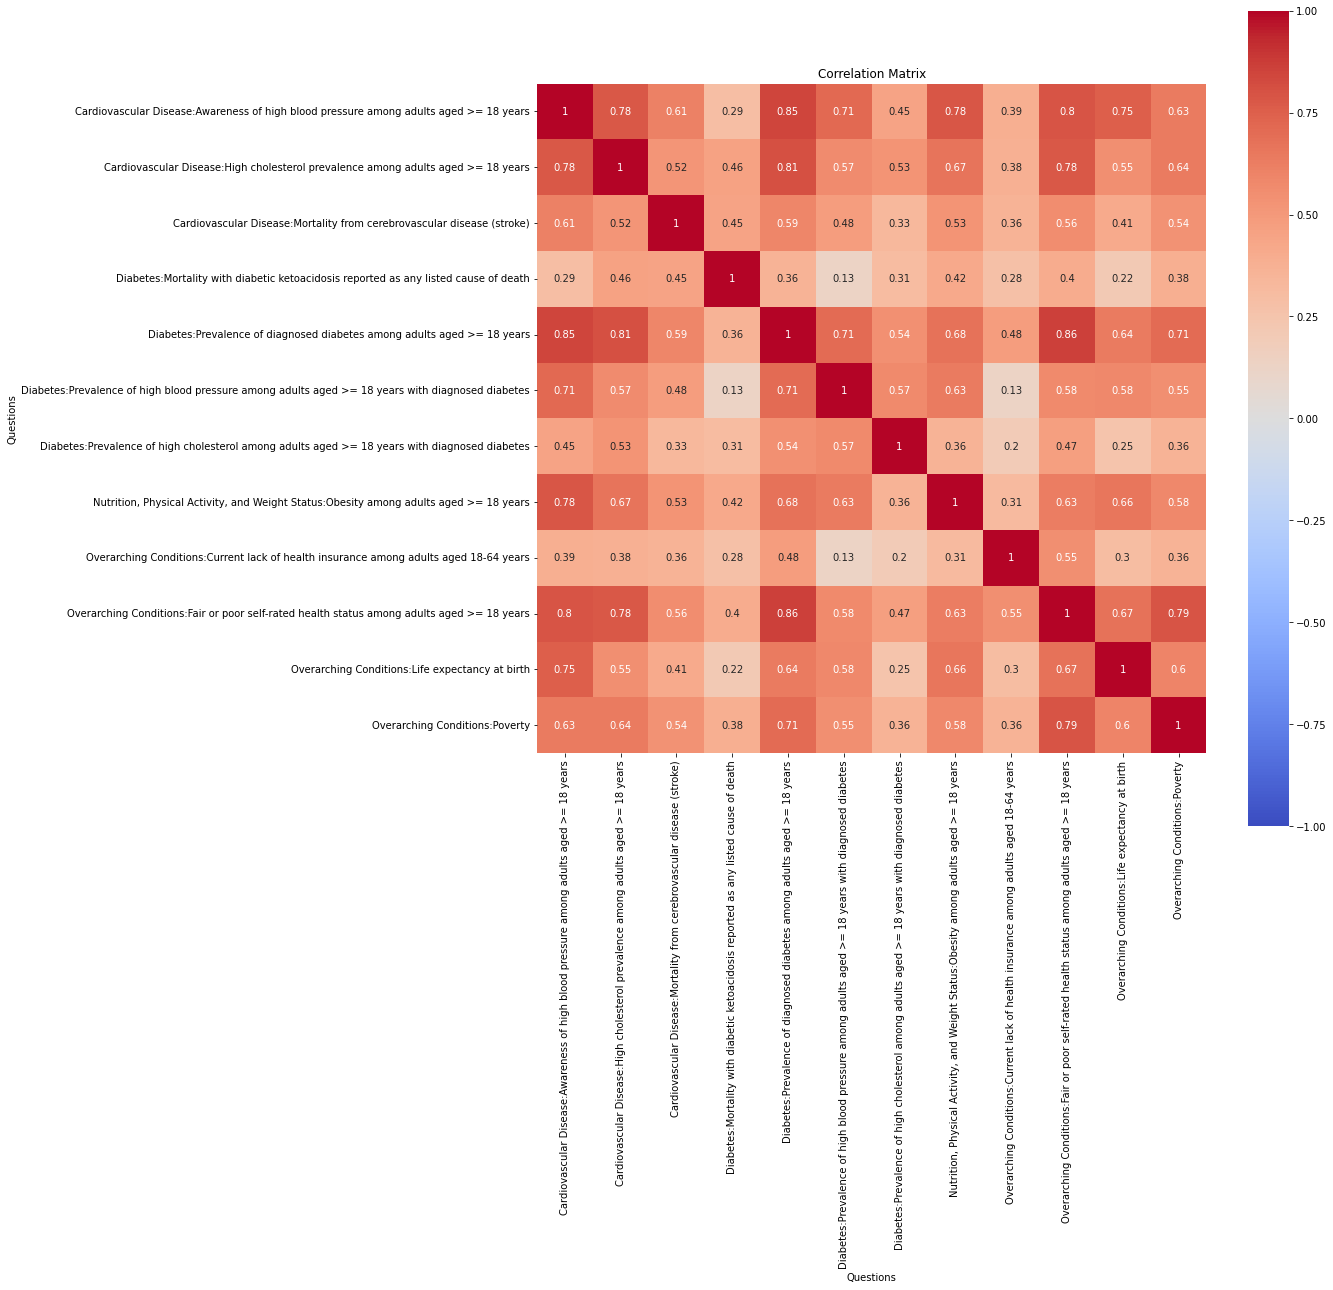

In [37]:
# Create a figure and axes objects with a larger size
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the heatmap using the axes object
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, square=True, vmin=-1, vmax=1, ax=ax)

# Set the title and axis labels
ax.set_title('Correlation Matrix')
ax.set_xlabel('Questions')
ax.set_ylabel('Questions')

# Display the plot
plt.show()


In [38]:
pivoted_data['locationdesc'] = pivoted_data.index
pivoted_data = pivoted_data.reset_index(drop=True)


In [39]:
pivoted_data

topic_question,Cardiovascular Disease:Awareness of high blood pressure among adults aged >= 18 years,Cardiovascular Disease:High cholesterol prevalence among adults aged >= 18 years,Cardiovascular Disease:Mortality from cerebrovascular disease (stroke),Diabetes:Mortality with diabetic ketoacidosis reported as any listed cause of death,Diabetes:Prevalence of diagnosed diabetes among adults aged >= 18 years,Diabetes:Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes,Diabetes:Prevalence of high cholesterol among adults aged >= 18 years with diagnosed diabetes,"Nutrition, Physical Activity, and Weight Status:Obesity among adults aged >= 18 years",Overarching Conditions:Current lack of health insurance among adults aged 18-64 years,Overarching Conditions:Fair or poor self-rated health status among adults aged >= 18 years,Overarching Conditions:Life expectancy at birth,Overarching Conditions:Poverty,locationdesc
0,39.4,32.7,51.5,2.0,12.2,69.4,57.5,36.3,18.0,21.6,75.2,15.5,Alabama
1,32.8,27.1,34.9,0.0,7.1,52.7,44.6,30.7,11.7,15.5,77.7,10.1,Alaska
2,29.9,30.5,30.2,1.2,9.8,59.4,50.8,31.9,19.0,18.5,78.8,13.5,Arizona
3,38.2,33.0,40.7,1.7,12.2,66.9,47.6,38.0,17.2,24.1,75.7,16.2,Arkansas
4,26.6,28.2,37.3,1.3,9.4,55.6,51.5,26.2,15.2,17.8,80.9,11.8,California
5,24.6,27.3,33.7,1.4,6.6,54.3,49.2,23.6,15.2,13.7,80.0,9.3,Colorado
6,27.6,31.0,26.7,1.1,8.3,53.0,48.1,29.1,10.6,14.4,80.3,10.0,Connecticut
7,32.4,30.1,45.1,0.0,10.9,76.4,43.7,34.2,13.5,17.9,78.1,11.3,Delaware
8,29.1,29.1,39.0,0.0,9.4,64.6,55.3,24.4,8.6,14.3,78.0,13.5,District of Columbia
9,28.8,28.8,40.4,1.0,9.4,58.8,50.5,26.3,21.3,18.2,79.0,12.7,Florida


In [40]:
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'illness_rates_USA.csv')  # construct the file path
pivoted_data.to_csv(file_path, index=False)

TimeoutError: [Errno 60] Operation timed out: '/Users/sarahbergquist/Library/CloudStorage/GoogleDrive-bergquistasarah@gmail.com/My Drive/NYU/Courses/CUSP-DataViz/final/illness_rates_USA.csv'